In [1]:
import pandas as pd
pd.options.display.max_rows = 999
import numpy as np
from scipy import stats
from scipy.stats import chisquare, chi2_contingency
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
cmap = sns.diverging_palette(230, 20, as_cmap=True)
palette = sns.diverging_palette(220, 20)
import pickle
%matplotlib inline
import random
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
df = pd.read_pickle('../data/interim/train_clean.pickle')
df.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,Census_OSBranch_release_extracted
0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,7.0,0,53447.0,1.0,1.0,1,...,36144.0,0,0,0,0,0,0,10.0,0,rs4_release
1,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,7.0,0,53447.0,1.0,1.0,1,...,57858.0,0,0,0,0,0,0,8.0,0,rs4_release
2,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,7.0,0,53447.0,1.0,1.0,1,...,52682.0,0,0,0,0,0,0,3.0,0,rs4_release
3,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,7.0,0,53447.0,1.0,1.0,1,...,20050.0,0,0,0,0,0,0,3.0,1,rs4_release
4,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,7.0,0,53447.0,1.0,1.0,1,...,19844.0,0,0,0,0,0,0,1.0,1,rs4_release


In [3]:
df.shape

(8921478, 72)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8921478 entries, 0 to 8921482
Data columns (total 72 columns):
 #   Column                                             Dtype   
---  ------                                             -----   
 0   ProductName                                        category
 1   EngineVersion                                      category
 2   AppVersion                                         category
 3   AvSigVersion                                       category
 4   RtpStateBitfield                                   category
 5   IsSxsPassiveMode                                   Int64   
 6   AVProductStatesIdentifier                          category
 7   AVProductsInstalled                                category
 8   AVProductsEnabled                                  category
 9   HasTpm                                             Int64   
 10  CountryIdentifier                                  category
 11  CityIdentifier                       

In [5]:
cat_col = df.select_dtypes('category').columns.tolist()
binary_col = df.select_dtypes('Int64').columns.tolist()
num_col = [col for col in df.columns 
           if col not in cat_col
           if col not in binary_col]

## Numerical data

In [6]:
df[num_col].head(10)

,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical
0,4.0,476940.0,299451.0,4096.0,18.900000,1440.0,900.0
1,4.0,476940.0,102385.0,4096.0,13.900000,1366.0,768.0
2,4.0,114473.0,113907.0,4096.0,21.500000,1920.0,1080.0
3,4.0,238475.0,227116.0,4096.0,18.500000,1366.0,768.0
4,4.0,476940.0,101900.0,6144.0,14.000000,1366.0,768.0
5,2.0,114473.0,113671.0,8192.0,21.500000,1920.0,1080.0
6,2.0,476940.0,458702.0,4096.0,17.200001,1600.0,900.0
7,2.0,305245.0,290807.0,4096.0,15.500000,1366.0,768.0
8,4.0,305245.0,303892.0,4096.0,15.600000,1920.0,1080.0
9,4.0,953869.0,203252.0,8192.0,15.500000,1366.0,768.0


In [7]:
df[num_col].describe().T

,count,mean,std,min,25%,50%,75%,max
Census_ProcessorCoreCount,8880172.0,3.989694,2.082554,1.0,2.0,4.0,4.000000,1.920000e+02
Census_PrimaryDiskTotalCapacity,8868462.0,513096.687500,363716.062500,0.0,239372.0,476940.0,953869.000000,9.537024e+07
Census_SystemVolumeTotalCapacity,8868476.0,377367.843750,325879.031250,0.0,120775.0,249500.0,475973.000000,4.768710e+07
Census_TotalPhysicalRAM,8840945.0,6115.259766,5115.821777,255.0,4096.0,4096.0,8192.000000,1.572864e+06
Census_InternalPrimaryDiagonalDisplaySizeInInches,8874344.0,16.676197,5.892929,3.0,13.9,15.5,17.200001,1.823000e+02
Census_InternalPrimaryDisplayResolutionHorizontal,8874336.0,1547.743408,368.317566,144.0,1366.0,1366.0,1920.000000,1.228800e+04
Census_InternalPrimaryDisplayResolutionVertical,8874336.0,897.587463,214.592697,171.0,768.0,768.0,1080.000000,8.640000e+03


Census_InternalPrimaryDiagonalDisplaySizeInInches is continuous, the other variables are discrete, however we may treat them as continuous given the number of counts and dimension of dataset.

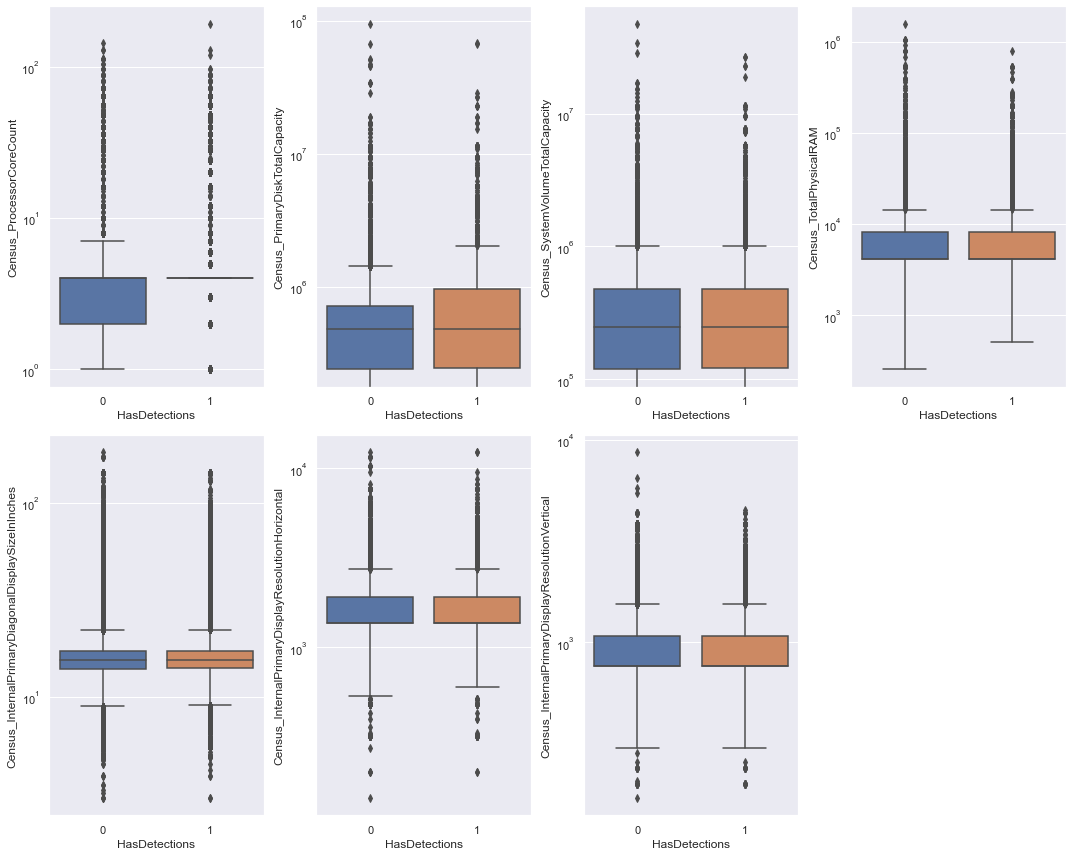

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(15, 12))

for col, ax in zip(num_col, axes.flatten()):
    sns.boxplot(data=df,
                y=col, 
                x='HasDetections',
                orient='v', 
                ax=ax)
    ax.set_yscale('log')

axes.flat[-1].set_visible(False)
plt.subplots_adjust(wspace=2.5)
plt.tight_layout()

In [9]:
num_col_name_dict = {'Census_ProcessorCoreCount':'Number of Cores',
                     'Census_PrimaryDiskTotalCapacity':'Disk Capacity (MB)',
                     'Census_SystemVolumeTotalCapacity':'System Capacity (MB)',
                     'Census_TotalPhysicalRAM': 'RAM (MB)',
                     'Census_InternalPrimaryDiagonalDisplaySizeInInches':'Display Size (in)',
                     'Census_InternalPrimaryDisplayResolutionHorizontal':'Horizontal Resolution (px)',
                     'Census_InternalPrimaryDisplayResolutionVertical':'Vertical Resolution (px)',
                     }
bin_col_name_dict = {'IsSxsPassiveMode':'Passive Mode',
                     'HasTpm':'Tpm',
                     'AutoSampleOptIn':'Auto Sample',
                     'SMode':'SMode',
                     'Firewall':'Firewall',
                     'Census_HasOpticalDiskDrive':'Optical Disk Drive',
                     'Census_IsPortableOperatingSystem':'Portable OS',
                     'Census_IsFlightsDisabled':'Flights Disabled',
                     'Census_IsSecureBootEnabled':'Secure Boot',
                     'Census_IsVirtualDevice':'Virtual Device',
                     'Census_IsTouchEnabled':'Touch Enabled',
                     'Census_IsPenCapable':'Pen Capable',
                     'Census_IsAlwaysOnAlwaysConnectedCapable':'Always Connected Capable',
                     'Wdft_IsGamer':'Gamer',
                     'HasDetections':'HasDetections'
                     }

<Figure size 1080x1080 with 0 Axes>

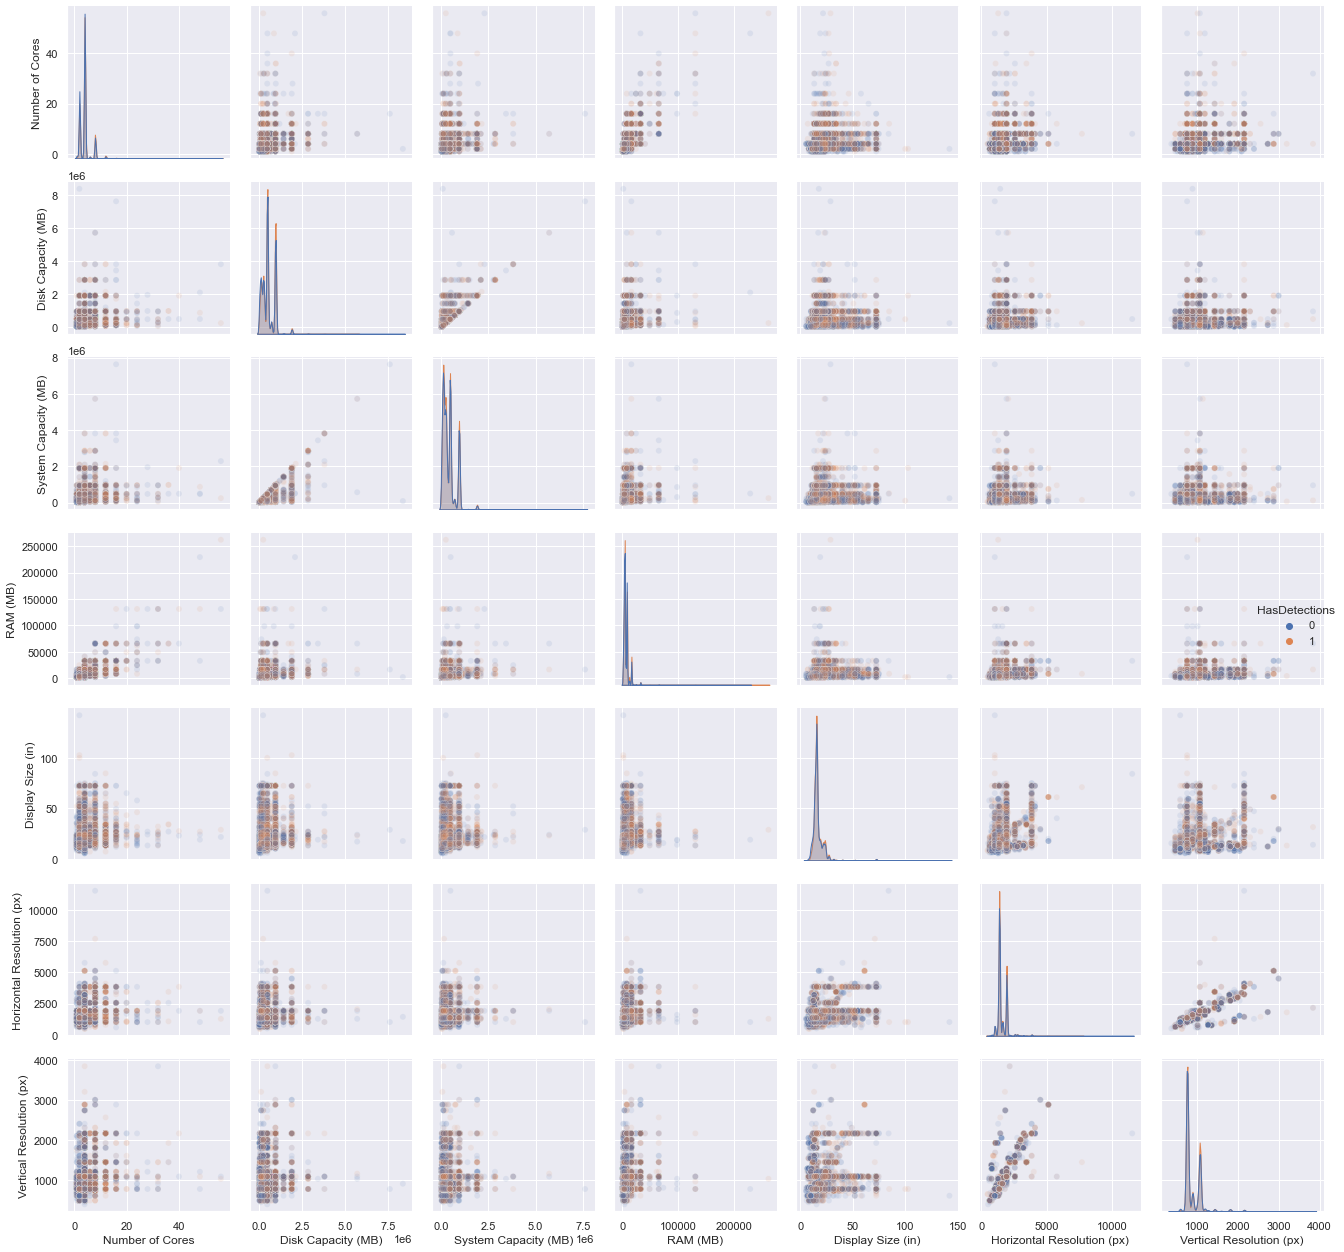

In [10]:
df_sample = df[num_col+['HasDetections']].rename(columns=num_col_name_dict).sample(frac=0.01, random_state=42)

plt.figure(figsize=(15,15))
sns.pairplot(df_sample, 
             hue='HasDetections', 
             #kind='reg',
             diag_kind='kde',
             plot_kws={'alpha': 0.1})
             #plot_kws={'scatter_kws': {'alpha': 0.1}})
plt.subplots_adjust(hspace=.2, wspace=.2)
plt.tight_layout();

The numerical features do not seem separable. Horizontal and vertical resolution are highly correlated. Also system and disk capacity, and RAM and number of cores are correlated. The other feature do not show a particular relationship between eachother. Even if the obvious outliers were removed in the data wrangling notebook, there still is a number of rare values. I will initially choose ML algorithms which are not sensitive to outliers, I might iterate a second time withoput to evaluate the performace without outliers. However, since these numerical features do not seem very predictive, outliers should not play a big role. 

Let's check the correlation between features. Note that we are violating Pearson correlation assumptions:
  - Most values are ordinal, however the Level of measurement are high enough to consider these variables as continuos;
  - Variables are not normal and error variance is not constant across the features (Heteroscedasticity);
  - As seen, we still have outliers.
 
Spearman's correlation, which only requires ordinal data and the scores of variables monotonically related to the other variable, is more appropriate in this case. I will proceed with both correlations, but Spearman should be considered as the more reliable here.

<AxesSubplot:>

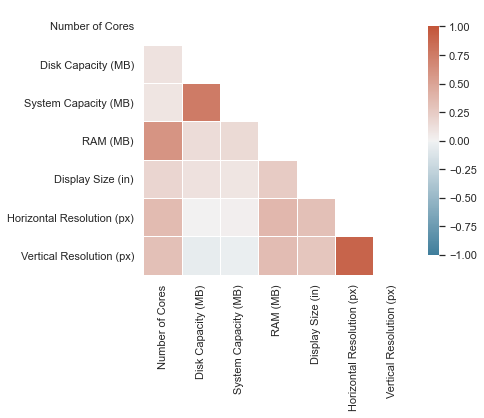

In [11]:
sns.set_style('whitegrid')
corr_matrix = df[num_col].rename(columns=num_col_name_dict).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(6,6))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

<AxesSubplot:>

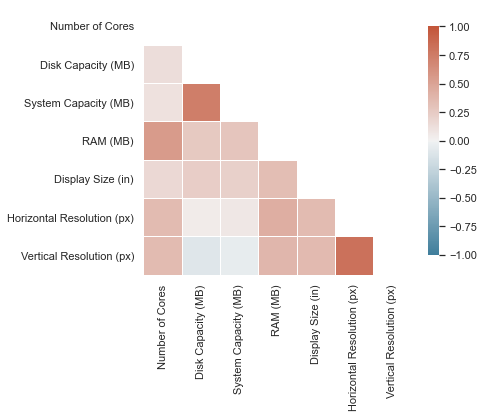

In [12]:
corr_matrix = df[num_col].rename(columns=num_col_name_dict).corr('spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(6,6))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

As expected the vertical and horizontal resolutions are highly correlated. Also the disk capacity and system capacity as one is a fraction of the other, and RAM and number of processor cores.

The target variable was also introduced in the correlation analisys (intended as point-biserial correlation, i.e. the correlation between a continuous variable and a dichotomous variable -  see following plots for point-biserial correlations).

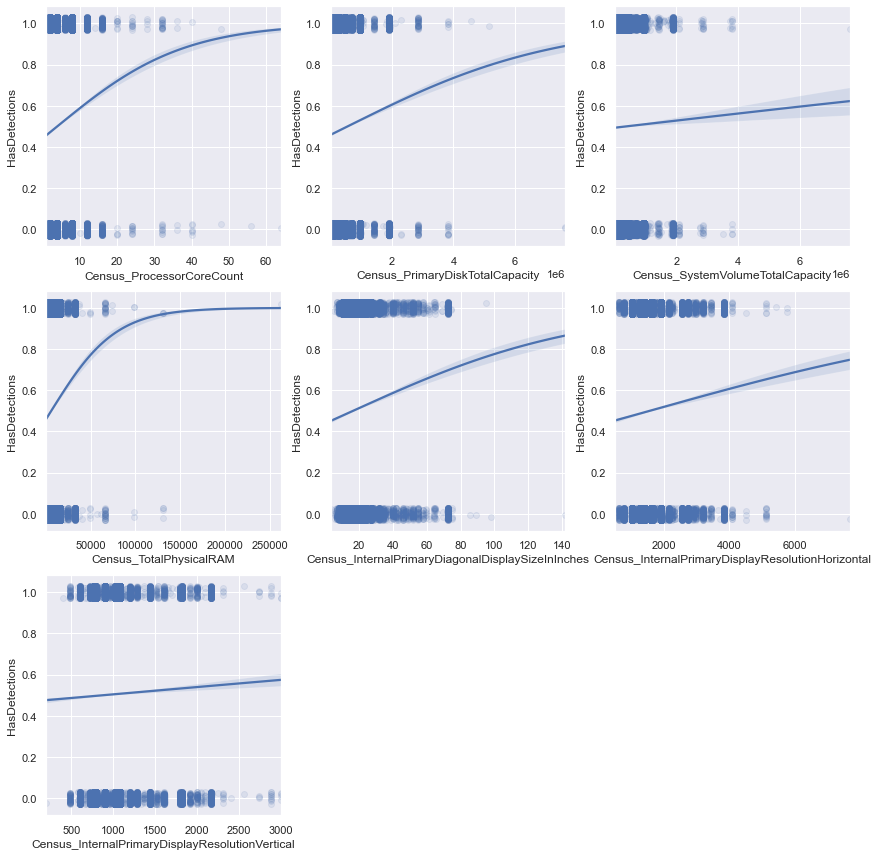

In [13]:
random.seed = 42

df['HasDetections'] = df['HasDetections'].astype('float')

sns.set_style('darkgrid')
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for col, ax in zip(num_col, axes.flatten()):
    sns.regplot(data=df[num_col+['HasDetections']].sample(frac=0.01),
                x=col,
                y='HasDetections',
                logistic=True, 
                n_boot=500, 
                y_jitter=.03,
                ax=ax,
                scatter_kws={'alpha':0.1})
axes.flat[-1].set_visible(False)
axes.flat[-2].set_visible(False)
plt.subplots_adjust(hspace=1.5, wspace=0.5)
plt.tight_layout()

Let's look at it without outliers:

In [14]:
z_score = np.abs(stats.zscore(df[num_col], nan_policy='omit'))
sum(z_score>3)/df[num_col].shape[0]*100

array([1.33069879, 1.23333824, 0.82981766, 0.9000975 , 1.22248802,
       1.72831228, 1.95568492])

In [15]:
outlier_indices = df[num_col][z_score > 3].index
no_df = df.iloc[~df.index.isin(outlier_indices), :]
no_df.shape

(8395370, 72)

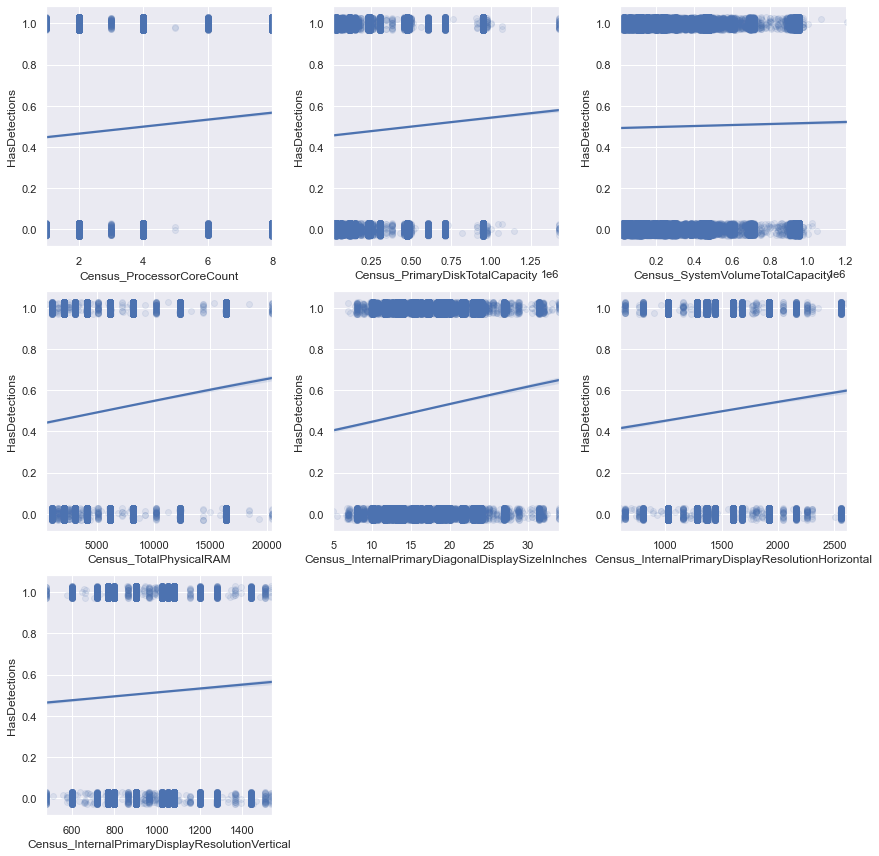

In [16]:
random.seed = 42

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for col, ax in zip(num_col, axes.flatten()):
    sns.regplot(data=no_df[num_col+['HasDetections']].sample(frac=0.01),
                x=col,
                y='HasDetections',
                logistic=True, 
                n_boot=500, 
                y_jitter=.03,
                ax=ax,
                scatter_kws={'alpha':0.1})
axes.flat[-1].set_visible(False)
axes.flat[-2].set_visible(False)
plt.subplots_adjust(hspace=1.5, wspace=0.5)
plt.tight_layout()

T-test

In [17]:
f_stat, p_val = f_classif(df[num_col].dropna(), df.loc[df[num_col].dropna().index, 'HasDetections'])
t_test = pd.DataFrame({'T-statistics':f_stat, 'p-value':p_val}, index=num_col)    
t_test.sort_values('T-statistics', ascending=False)

,T-statistics,p-value
Census_TotalPhysicalRAM,29693.705659,0.0
Census_ProcessorCoreCount,27240.803776,0.0
Census_PrimaryDiskTotalCapacity,24298.393051,0.0
Census_InternalPrimaryDisplayResolutionHorizontal,12321.969030,0.0
Census_InternalPrimaryDiagonalDisplaySizeInInches,9838.763639,0.0
Census_InternalPrimaryDisplayResolutionVertical,2483.087013,0.0
Census_SystemVolumeTotalCapacity,2181.918036,0.0


In [18]:
df_drop_nan = df.dropna()
t_list = []
pval_list = []
for col in num_col:
    a = df_drop_nan.loc[df_drop_nan['HasDetections']==0, col]
    b = df_drop_nan.loc[df_drop_nan['HasDetections']==1, col]
    t, pval = stats.ttest_ind(a, b, equal_var=True)
    t_list.append(t)
    pval_list.append(pval)
    
t_test_scipy = pd.DataFrame(zip(num_col, t_list, pval_list), columns=['Feature', 't-score', 'p-value'])
t_test_scipy.sort_values('t-score')

,Feature,t-score,p-value
2,Census_SystemVolumeTotalCapacity,-42.136247,0.0
6,Census_InternalPrimaryDisplayResolutionVertical,-43.495661,0.0
4,Census_InternalPrimaryDiagonalDisplaySizeInInches,-68.692350,0.0
5,Census_InternalPrimaryDisplayResolutionHorizontal,-84.612496,0.0
1,Census_PrimaryDiskTotalCapacity,-91.536480,0.0
0,Census_ProcessorCoreCount,-111.656533,0.0
3,Census_TotalPhysicalRAM,-142.784967,0.0


### Binary features

In [19]:
binary_df = df[binary_col].copy().astype('float')

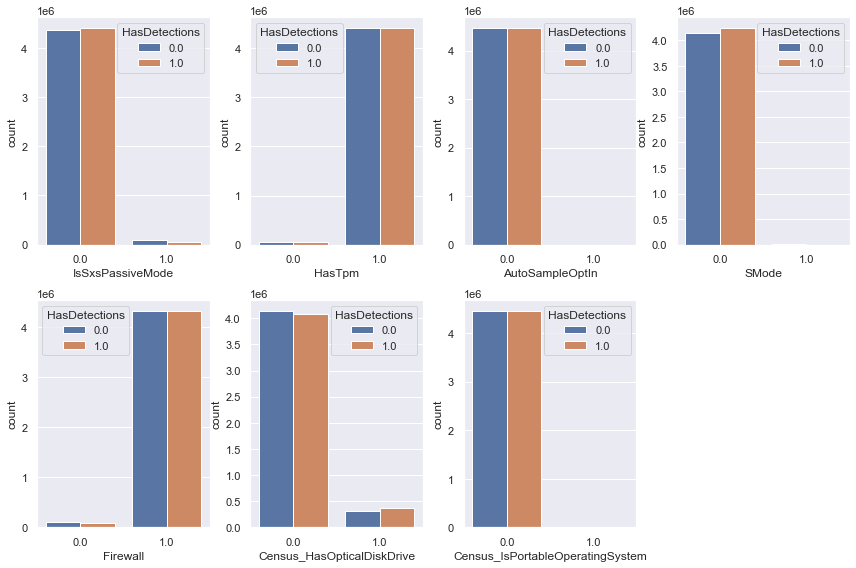

In [20]:
fig, axes = plt.subplots(2, 4, figsize=(12, 8))

for col, ax in zip(binary_col, axes.flatten()):
    sns.countplot(data=binary_df,
                  x=col, 
                  hue='HasDetections', 
                  ax=ax)

axes.flat[-1].set_visible(False)
plt.subplots_adjust(wspace=1.5)
plt.tight_layout()

IsSxsPassiveMode, SMode, Census_IsTouchEnabled, Census_IsAlwaysOnAlwaysConnectedCapable, Wdft_IsGamer show less detections for the positive class. 'Census_HasOpticalDiskDrive' has more detections for the positive class. The other features' classes are equally distribited among detection and no detection.  

<AxesSubplot:>

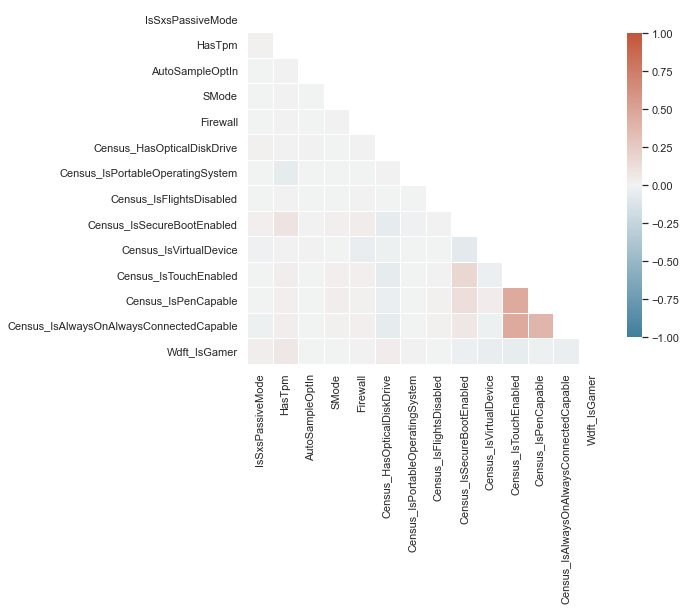

In [21]:
point_biserial_corr_matrix = binary_df.drop('HasDetections', axis=1).corr()
mask = np.triu(np.ones_like(point_biserial_corr_matrix, dtype=bool))
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(point_biserial_corr_matrix, vmin=-1, vmax=1, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\numpy\lib\nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


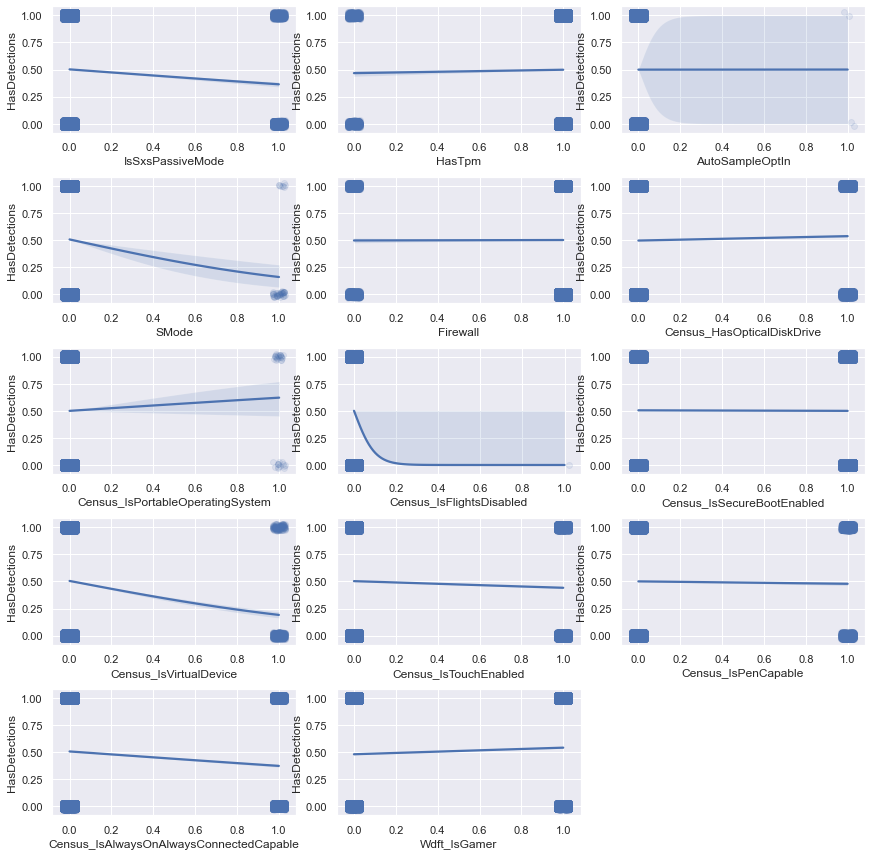

In [22]:
random.seed = 42

sns.set_style('darkgrid')
fig, axes = plt.subplots(5, 3, figsize=(12, 12))

for col, ax in zip(binary_col, axes.flatten()):
    sns.regplot(data=binary_df.sample(frac=0.01),
                x=col,
                y='HasDetections',
                logistic=True, 
                n_boot=500, 
                x_jitter=.03,
                y_jitter=.03,
                ax=ax,
                scatter_kws={'alpha':0.1})
axes.flat[-1].set_visible(False)
plt.subplots_adjust(hspace=1.5, wspace=0.5)

plt.tight_layout()

In [23]:
chi2_stat, p_val = chi2(binary_df.dropna(),
                        df.loc[binary_df.dropna().index, 'HasDetections'].astype('float'))
chi2_test = pd.DataFrame({'Chi2':chi2_stat, 'p-value':p_val}, index=binary_col)    
chi2_test.drop('HasDetections', axis=0).sort_values('Chi2', ascending=False)

,Chi2,p-value
Census_IsAlwaysOnAlwaysConnectedCapable,31341.015330,0.000000e+00
Census_IsVirtualDevice,23692.370834,0.000000e+00
Wdft_IsGamer,18702.007873,0.000000e+00
Census_IsTouchEnabled,11973.409378,0.000000e+00
IsSxsPassiveMode,11109.857001,0.000000e+00
Census_HasOpticalDiskDrive,3969.772355,0.000000e+00
Census_IsPenCapable,2356.217506,0.000000e+00
SMode,1720.713953,0.000000e+00
Census_IsSecureBootEnabled,143.063058,5.694341e-33
Census_IsPortableOperatingSystem,69.862668,6.358046e-17


#sample_df = df[binary_col].dropna().sample(frac=0.01, random_state=42).astype('int')
#mi = mutual_info_classif(sample_df[binary_col[:-1]], sample_df['HasDetections'])
#mi_df = pd.DataFrame({'Feature': binary_col[:-1], 'MI':mi})
#mi_df.sort_values('MI', ascending=False)


mi = mutual_info_classif(df[binary_col].dropna(),
                        df.loc[df[binary_col.dropna().index, 'HasDetections'].astype('float'))
mi_df = pd.DataFrame({'Feature': binary_col, 'MI':mi})                     
mi_df.drop('HasDetections', axis=0).sort_values('MI', ascending=False)

## Categorical Features

In [24]:
cardinality = df[cat_col].nunique().sort_values(ascending=False)
high_cardinality = cardinality[cardinality > 10].index
low_cardinality = cardinality[cardinality <= 10].index

In [25]:
for col in high_cardinality:
    print(f'Feature: {col} \nUnique Values Count: {df[col].nunique()}\n')   

Feature: Census_OEMModelIdentifier 
Unique Values Count: 175364

Feature: CityIdentifier 
Unique Values Count: 107366

Feature: Census_FirmwareVersionIdentifier 
Unique Values Count: 50493

Feature: AVProductStatesIdentifier 
Unique Values Count: 28970

Feature: AvSigVersion 
Unique Values Count: 8531

Feature: Census_OEMNameIdentifier 
Unique Values Count: 3832

Feature: Census_ProcessorModelIdentifier 
Unique Values Count: 3428

Feature: Census_FirmwareManufacturerIdentifier 
Unique Values Count: 712

Feature: Census_OSVersion 
Unique Values Count: 469

Feature: IeVerIdentifier 
Unique Values Count: 303

Feature: GeoNameIdentifier 
Unique Values Count: 292

Feature: Census_OSBuildRevision 
Unique Values Count: 285

Feature: LocaleEnglishNameIdentifier 
Unique Values Count: 252

Feature: CountryIdentifier 
Unique Values Count: 222

Feature: Census_OSUILocaleIdentifier 
Unique Values Count: 147

Feature: AppVersion 
Unique Values Count: 110

Feature: OsBuild 
Unique Values Count: 76

F

Many of these categorical features are Identifiers and show very high cardinality. Let's look at these in detail.  

In [26]:
id_col = [col for col in df.columns if 'Identifier' in col]
id_col

['AVProductStatesIdentifier',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'IeVerIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_OSInstallLanguageIdentifier',
 'Census_OSUILocaleIdentifier',
 'Census_FirmwareManufacturerIdentifier',
 'Census_FirmwareVersionIdentifier',
 'Wdft_RegionIdentifier']

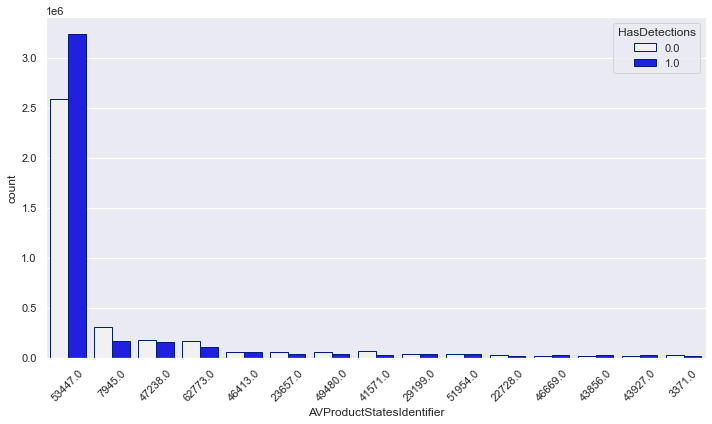

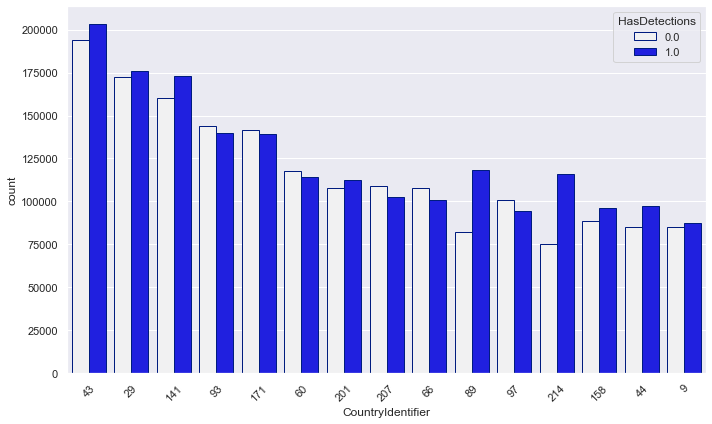

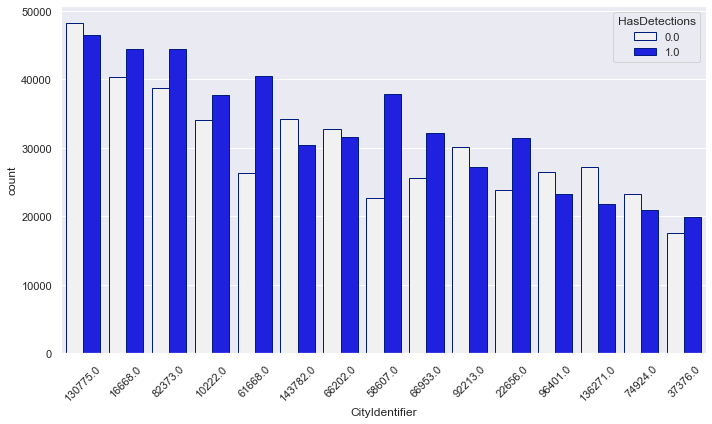

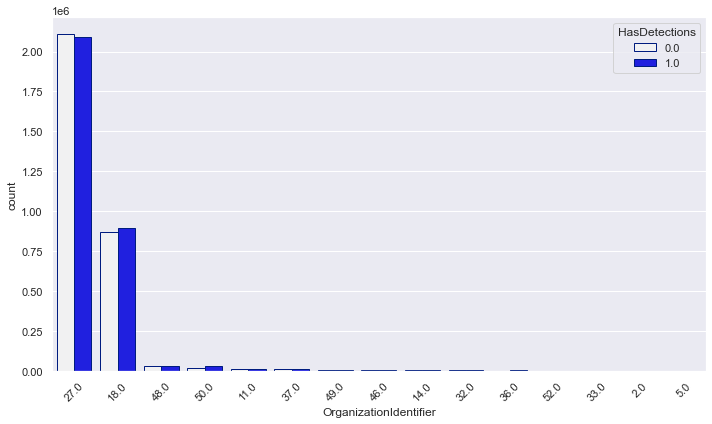

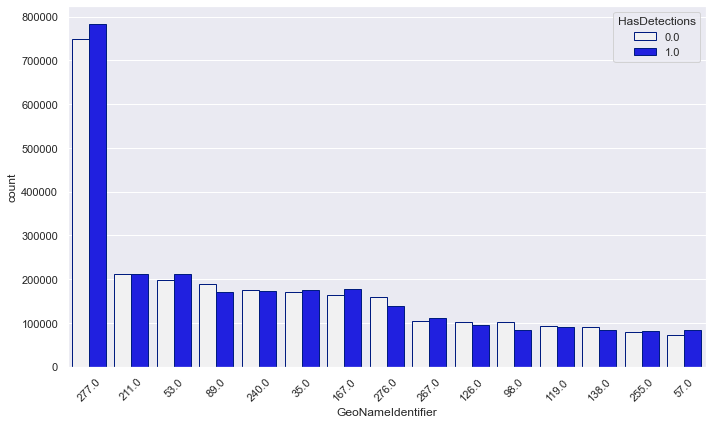

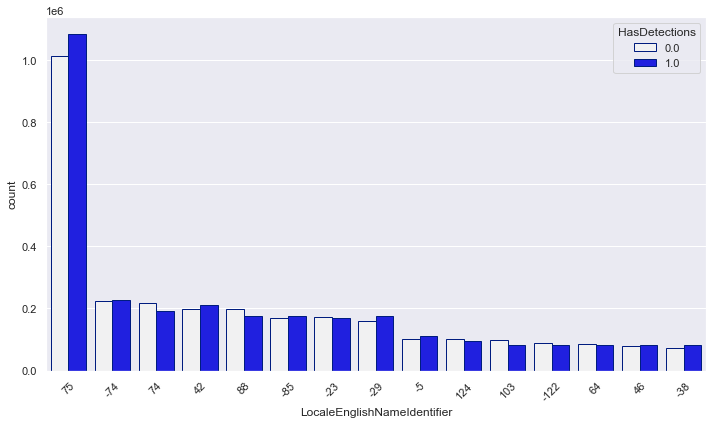

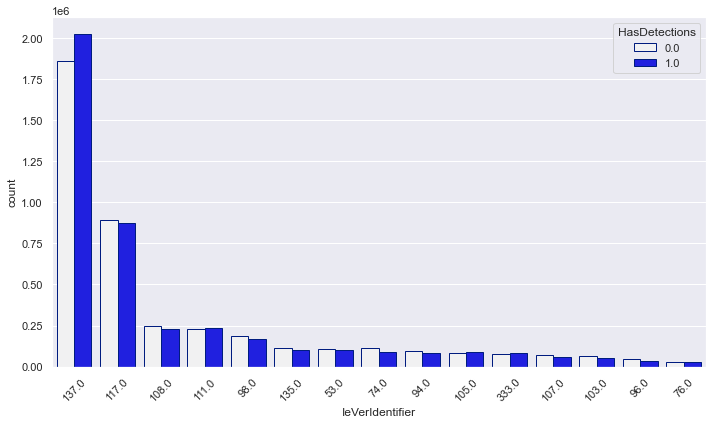

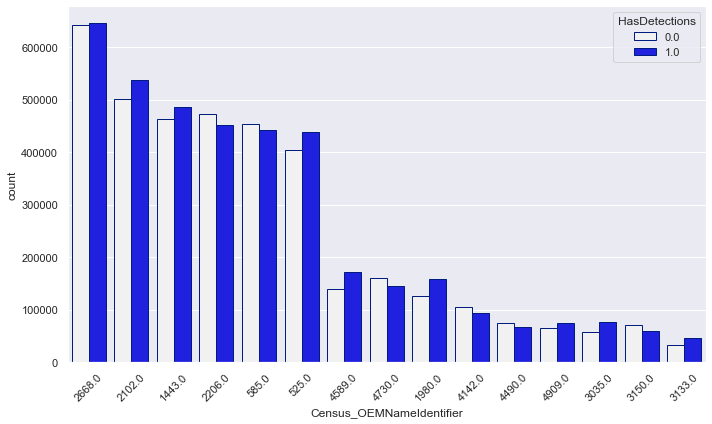

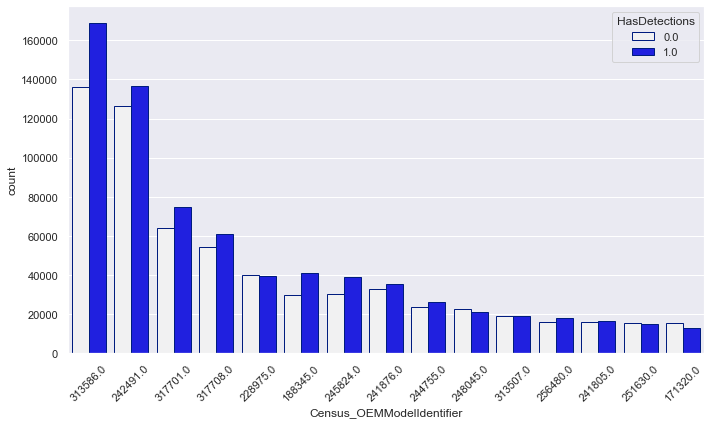

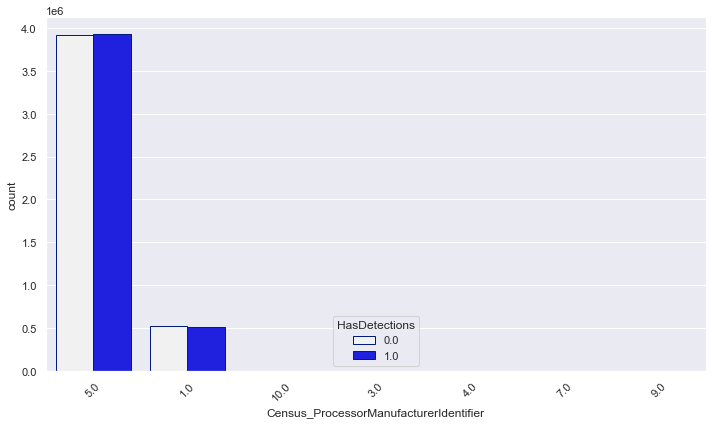

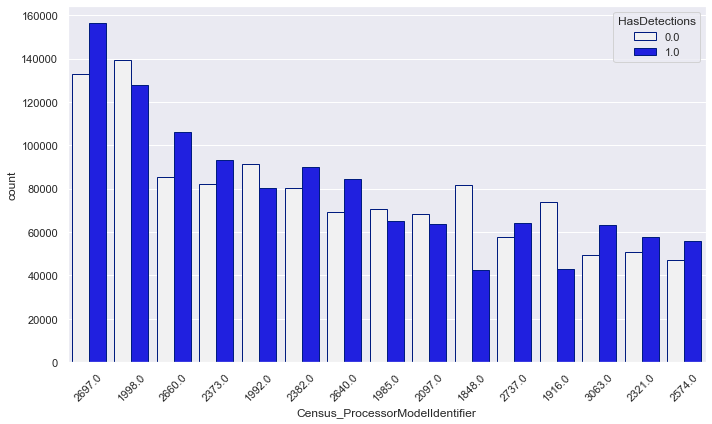

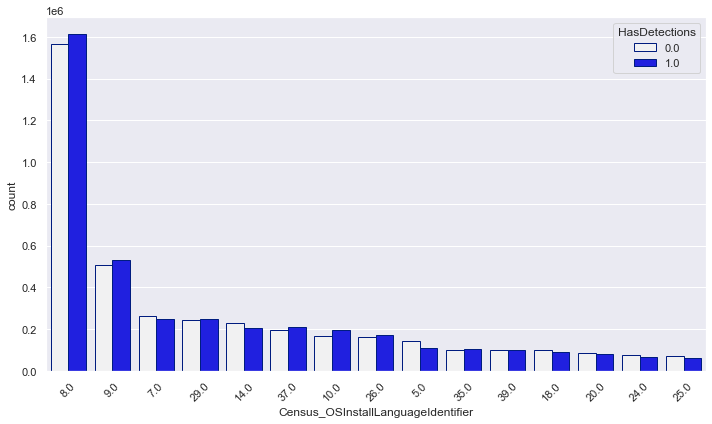

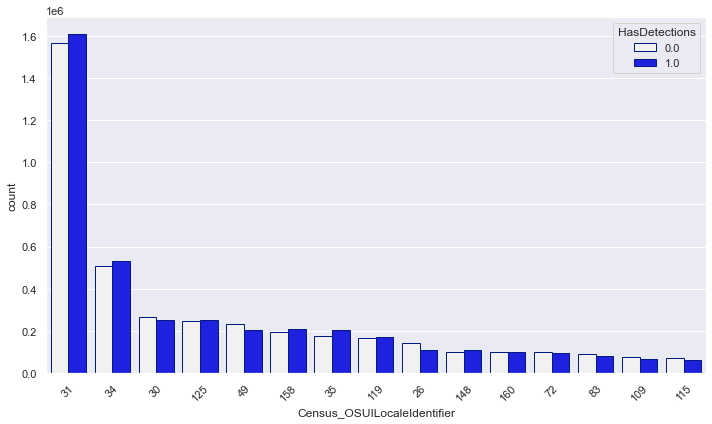

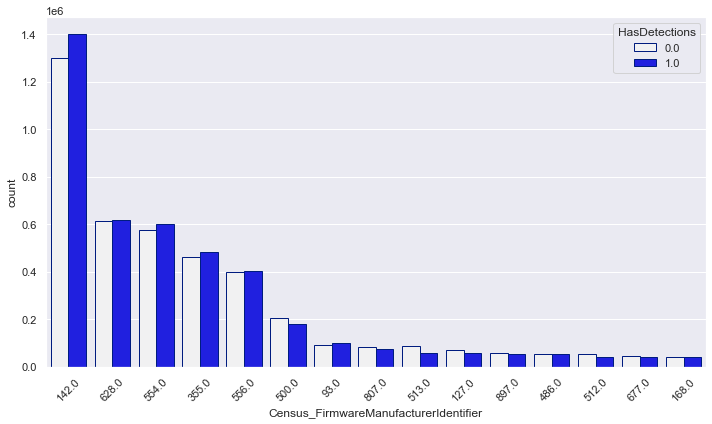

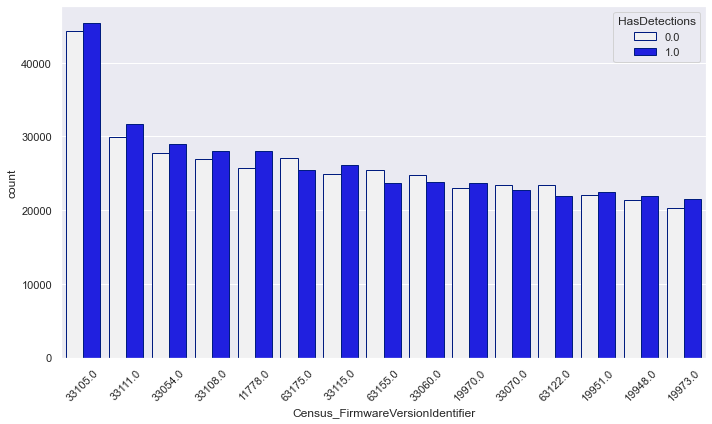

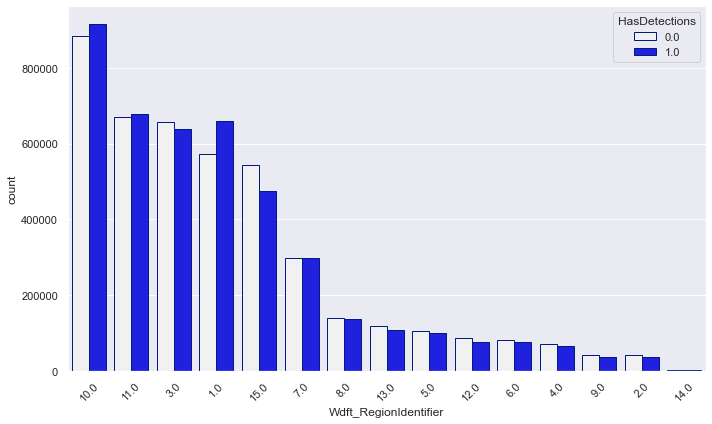

In [27]:
for col in id_col:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col,
                  hue='HasDetections',
                  data=df,
                  order=df[col].value_counts().index[:15],
                  color='blue',
                  edgecolor=sns.color_palette('dark', 1))
    #plt.legend(loc=1, title='HasDetections')
    plt.xticks(rotation = 45)
    plt.tight_layout();

These columns are label encoded. We can keep them like this or try different encodings, e.g. mean encoding (mean encoding).
Let's look at the remaining categorical features.

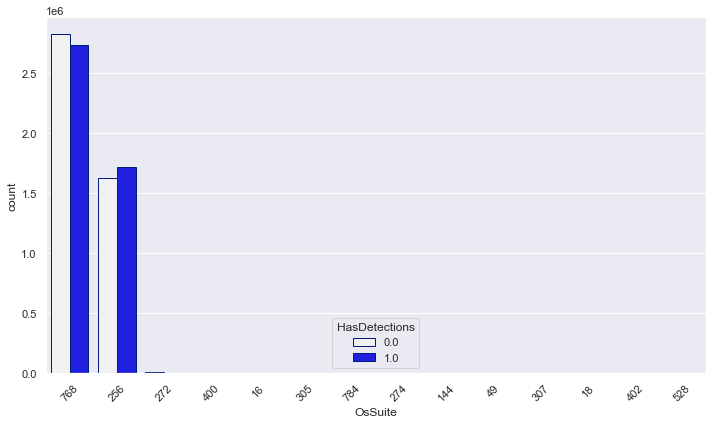

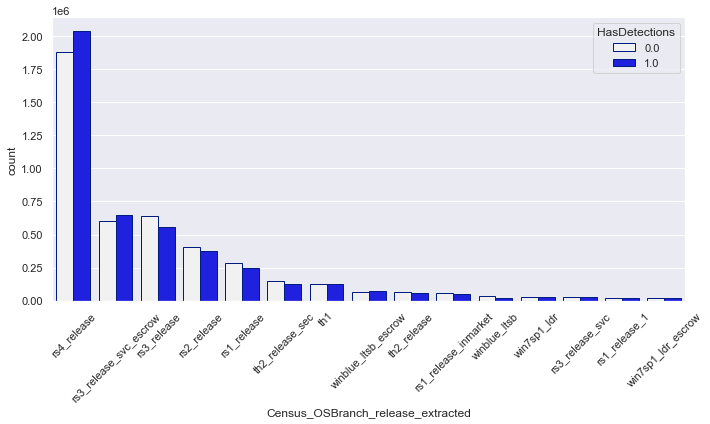

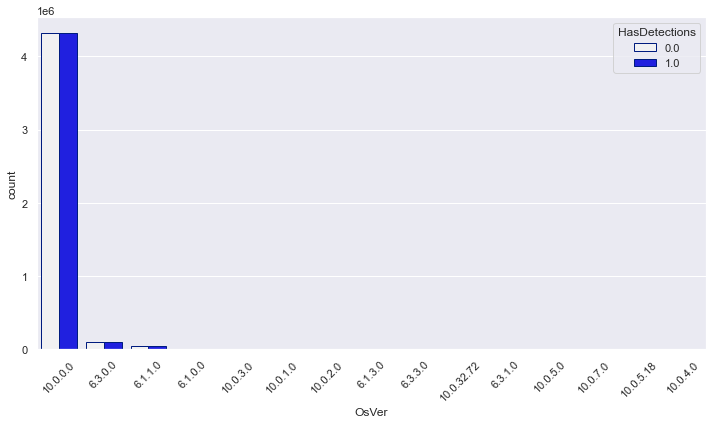

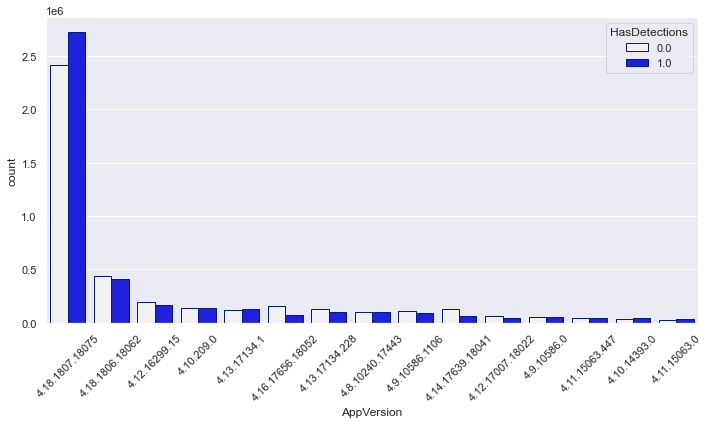

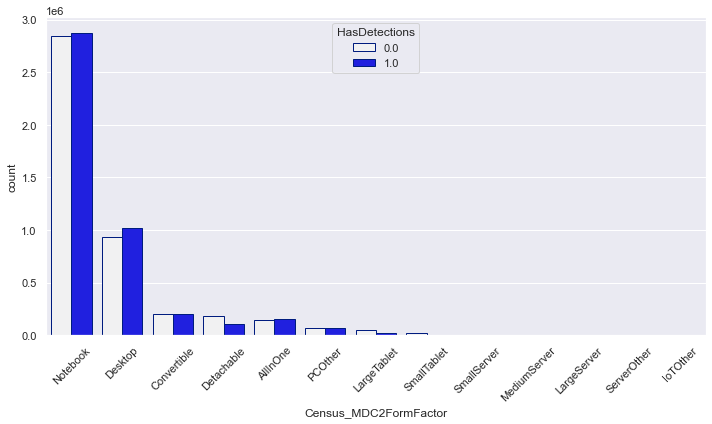

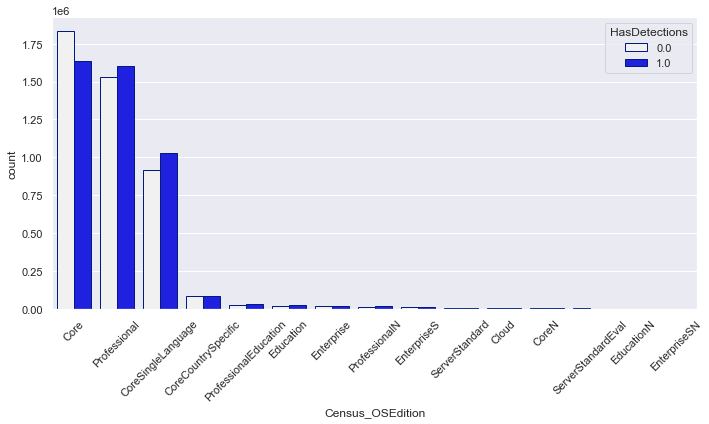

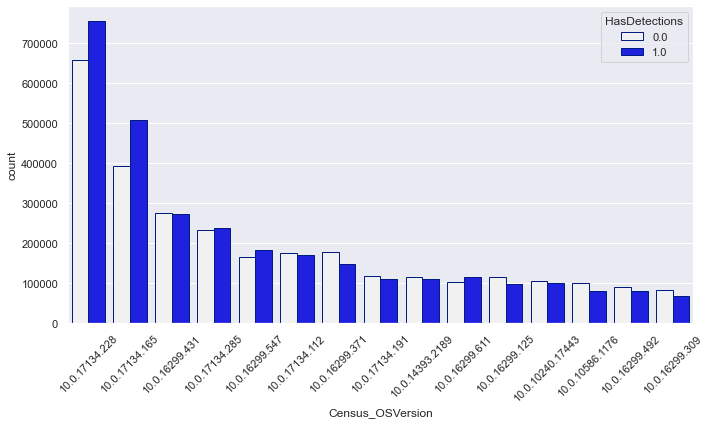

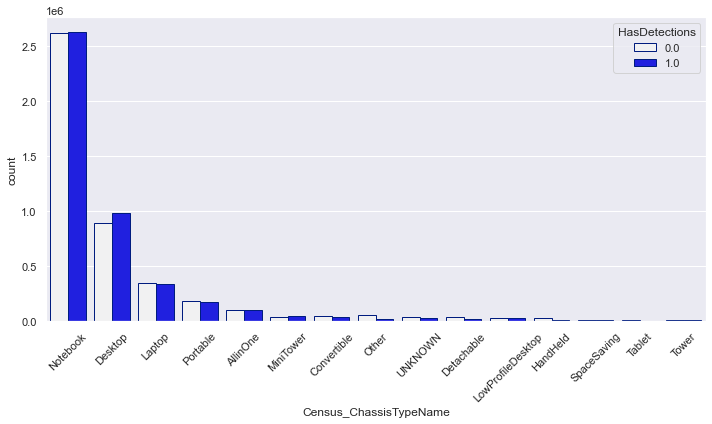

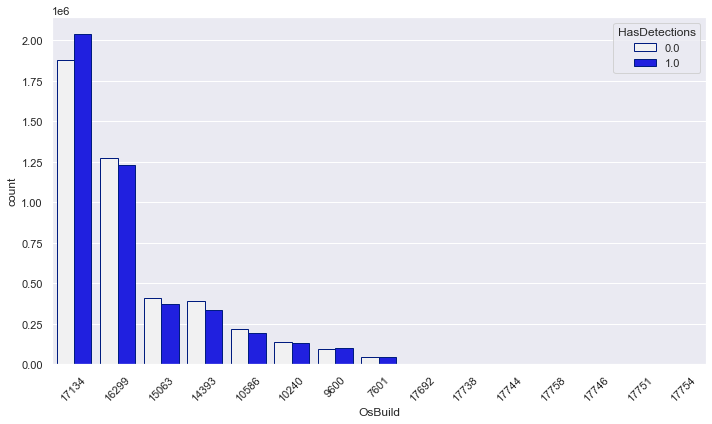

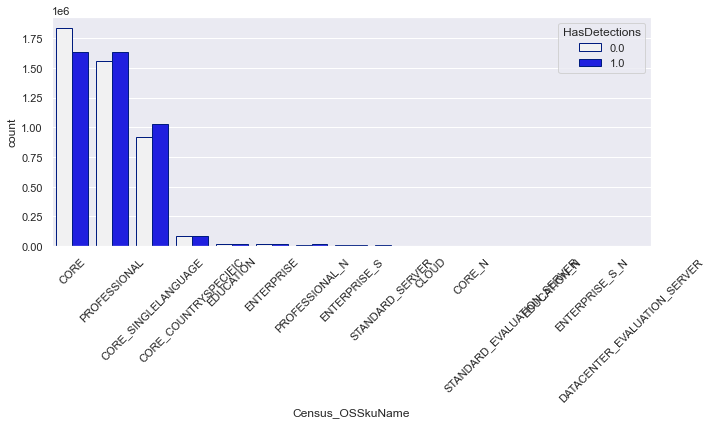

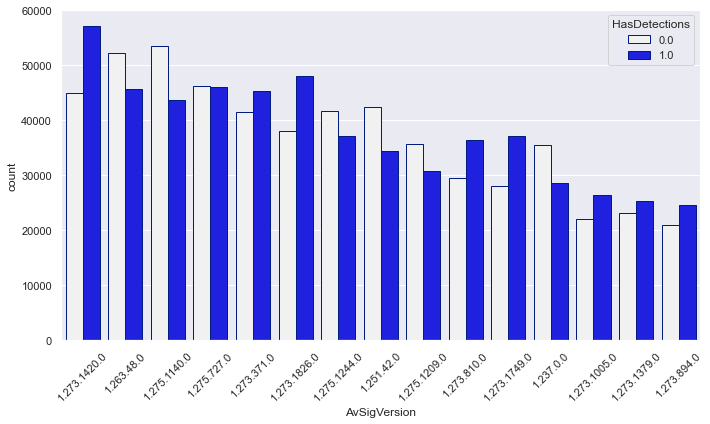

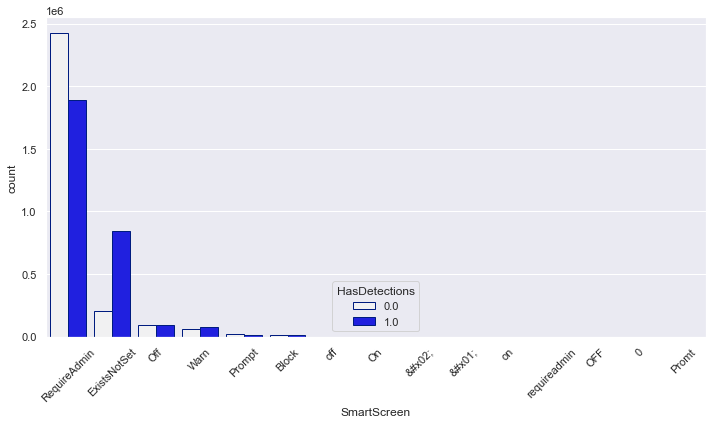

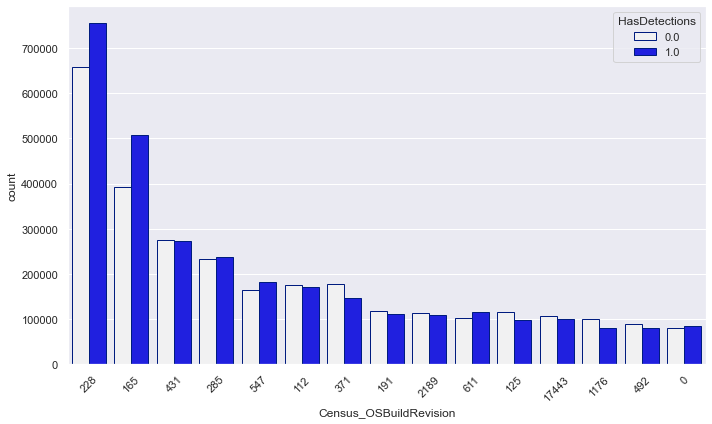

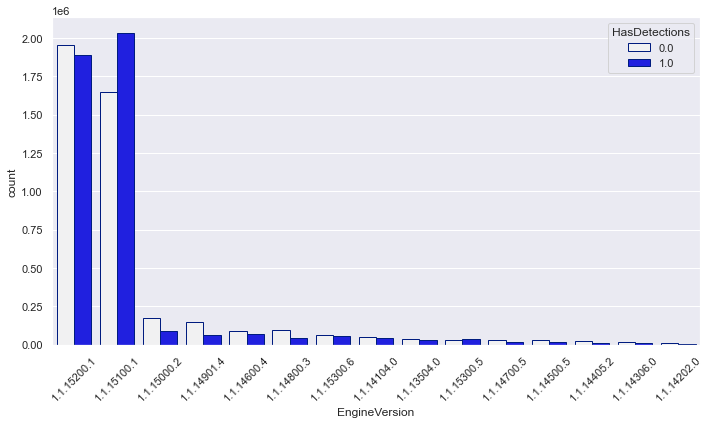

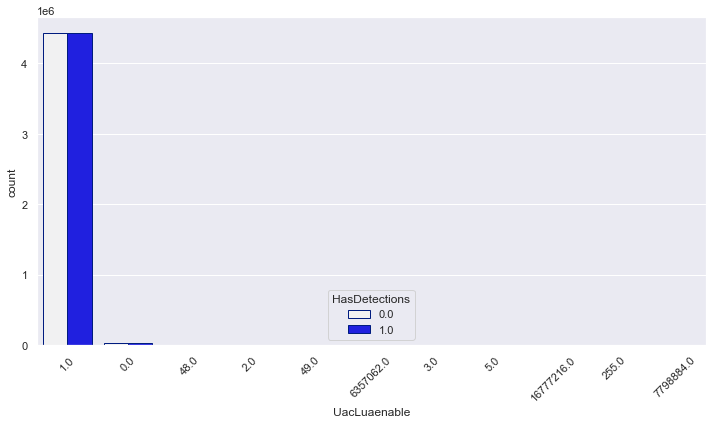

In [28]:
for col in list(set(high_cardinality) - set(id_col)):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col,
                  hue='HasDetections',
                  data=df,
                  order=df[col].value_counts().index[:15],
                  color='blue',
                  edgecolor=sns.color_palette('dark', 1))
    #plt.legend(loc=1, title='HasDetections')
    plt.xticks(rotation = 45)
    plt.tight_layout();

Some of these features require some feature engineering work, i.e. to extract information and reduce cardinality if a onehot encoding method is chosen, and thus increase robustness of the models. These operations are performed in the Feature_engineering notebook.

## Summary